In [2]:
import os
import time

# import sklearn.linear_model
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model as sklm
import sklearn.neural_network as sknn
import vaex
import vaex.ml
import vaex.ml.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# vaex.settings.main.thread_count = 20

In [3]:
features = ['EventType', 'EventDetails', 'EventCountry', 'Actor1Code', 'Actor1Name']
target = 'AvgTone'

In [4]:
def vx_reader(folder):
    print("Starting read")
    read_time = time.time()
    df = vaex.open(folder,
                   dtype={'Actor1Code': str,
                          'Actor1Name': str,
                          'EventCode': str,
                          'ActionGeo_ADM1Code': str,
                          'SQLDATE': str})
    print("Read completed in", time.time() - read_time, "seconds")
    print("Starting cleanup")
    clean_time = time.time()
    df.dropna()
    df = df[df.NumMentions > 2000]
    df = df[df.SQLDATE > 20000000]
    df['EventType'] = df.EventCode.str.slice(start=0, stop=2)
    df['EventDetails'] = df.EventCode.str.slice(start=2)
    df['EventCountry'] = df.ActionGeo_ADM1Code.str.slice(start=0, stop=2)
    df['EventRegion'] = df.ActionGeo_ADM1Code.str.slice(start=2)
    # df['Year'] = df.SQLDATE.str.slice(start=0, stop=4)
    # df['Month'] = df.SQLDATE.str.slice(start=4, stop=6)
    # df['Month'] = df.Month.astype('str')
    df = df.drop(['EventCode', 'ActionGeo_ADM1Code'])
    df = df.dropna()
    # df = df[df.NumMentions > 500]
    print("Cleanup completed in", time.time() - clean_time, "seconds")
    test = df[df.SQLDATE > 20200000]
    train = df[df.SQLDATE < 20200000]
    # print(df.head(5))
    return test, train, df


test_df, df, raw = vx_reader("data")

Starting read
Read completed in 0.9474997520446777 seconds
Starting cleanup
Cleanup completed in 1.1120021343231201 seconds


In [5]:
def binary_encode(df, test_df, features):
    binary_encoder = vaex.ml.MultiHotEncoder(features=features)
    binary_encoded_df = binary_encoder.fit_transform(df)
    binary_encoded_test = binary_encoder.transform(test_df)
    return binary_encoded_df, binary_encoded_test


bin_df, bin_test = binary_encode(df, test_df, features)

<function matplotlib.pyplot.show(close=None, block=None)>

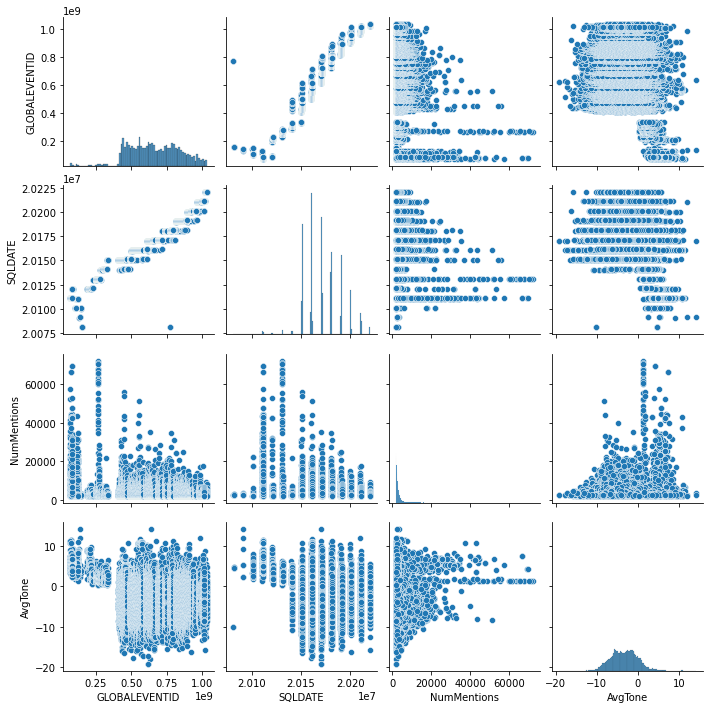

In [6]:
bin_pd = bin_df.to_pandas_df()
test_pd = bin_test.to_pandas_df()
raw_pd = raw.to_pandas_df()
sns.pairplot(raw_pd)
plt.show

In [7]:
print(test_pd.head())

   GLOBALEVENTID   SQLDATE Actor1Code        Actor1Name  NumMentions  \
0      956483332  20201126        GOV          GOVERNOR         2228   
1      956436266  20201126        CRM          CRIMINAL         2719   
2      956436807  20201126        GOV  ATTORNEY GENERAL         2026   
3      956466335  20201126        GOV           MONARCH         2187   
4      956614494  20201127        USA          AMERICAN         2139   

    AvgTone EventType EventDetails EventCountry EventRegion  ...  \
0 -1.669341        05            0           US          NY  ...   
1 -2.658632        08            0           RS              ...   
2 -2.991468        02            0           RS              ...   
3  1.217056        03            6           UK          C3  ...   
4 -3.192004        02            0           US          DC  ...   

   Actor1Name_2  Actor1Name_3  Actor1Name_4  Actor1Name_5  Actor1Name_6  \
0             1             0             0             1             1   
1       

In [8]:
def lin_reg(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = pd.DataFrame(df['AvgTone'])
    print(y.head())
    y_test = pd.DataFrame(test_df['AvgTone'])
    print(y_test.head())
    model = sklm.LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    score = model.score(X_test,y_test)
    print(score)
    # print(preds)
    return preds, score

lin_reg_preds, lin_reg_score = lin_reg(bin_pd, test_pd)


   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         2216        19            0            1            0            0   
1         2212        19            0            1            0            0   
2         2212        14            1            0            1            1   
3         2212        14            1            0            1            1   
4         2238        14            1            0            1            1   

   EventType_3  EventType_4  EventDetails_0  EventDetails_1  ...  \
0            1            1               0               0  ...   
1            1            1               0               0  ...   
2            1            0               0               0  ...   
3            1            0               0               0  ...   
4            1            0               0               0  ...   

   Actor1Name_2  Actor1Name_3  Actor1Name_4  Actor1Name_5  Actor1Name_6  \
0             1             0      

In [10]:
def random_forest(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.ensemble.RandomForestRegressor(n_jobs=-1)
    model.fit(X, y)
    path = model.decision_path(X)
    score = model.score(X_test, y_test)
    print(score)
    return path, score

rf_path, rf_score = random_forest(bin_pd, test_pd)

   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         2216        19            0            1            0            0   
1         2212        19            0            1            0            0   
2         2212        14            1            0            1            1   
3         2212        14            1            0            1            1   
4         2238        14            1            0            1            1   

   EventType_3  EventType_4  EventDetails_0  EventDetails_1  ...  \
0            1            1               0               0  ...   
1            1            1               0               0  ...   
2            1            0               0               0  ...   
3            1            0               0               0  ...   
4            1            0               0               0  ...   

   Actor1Name_2  Actor1Name_3  Actor1Name_4  Actor1Name_5  Actor1Name_6  \
0             1             0      

In [ ]:
def svm(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sklearn.svm.SVR()
    model.fit(X, y)
    predict = model.predict(X)
    score = model.score(X_test, y_test)
    print(score)
    return predict, score

svm_pred, svm_score = svm(bin_pd, test_pd)

In [11]:
def nn(df, test_df):
    X = df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X.head())
    X_test = test_df.drop(['GLOBALEVENTID', 'SQLDATE', 'Actor1Code', 'Actor1Name', 'EventCountry', 'EventRegion', 'AvgTone'], axis=1)
    print(X_test.head())
    y = np.ravel(pd.DataFrame(df['AvgTone']))
    # print(y.head())
    y_test = np.ravel(pd.DataFrame(test_df['AvgTone']))
    # print(y_test.head())
    model = sknn.MLPRegressor(early_stopping=True, max_iter=1000, learning_rate='adaptive')
    model.fit(X.values, y)
    preds = model.predict(X.values)
    score = model.score(X_test.values, y_test)
    # print(model.n_iter)
    print(score)
    return preds, score

nn_preds, nn_score = nn(bin_pd, test_pd)

   NumMentions EventType EventDetails  EventType_0  EventType_1  EventType_2  \
0         2216        19            0            1            0            0   
1         2212        19            0            1            0            0   
2         2212        14            1            0            1            1   
3         2212        14            1            0            1            1   
4         2238        14            1            0            1            1   

   EventType_3  EventType_4  EventDetails_0  EventDetails_1  ...  \
0            1            1               0               0  ...   
1            1            1               0               0  ...   
2            1            0               0               0  ...   
3            1            0               0               0  ...   
4            1            0               0               0  ...   

   Actor1Name_2  Actor1Name_3  Actor1Name_4  Actor1Name_5  Actor1Name_6  \
0             1             0      

In [12]:
print(bin_pd.shape)
print(test_pd.shape)
print("R2's:")
print("LinReg:", lin_reg_score)
print("Random Forest:", rf_score)
print("SVR:", svm_score)
print("NN:", nn_score)

(68048, 52)
(8364, 52)
R2's:
LinReg: 0.2339005100143693
Random Forest: 0.20765333501975503


NameError: name 'svm_score' is not defined